# **W24 EECS 442 HW6: Neural Radiance Fields**

__Please provide the following information__

[Your first name] [Your last name], [Your UMich uniqname]

## Brief Overview

In this problem set, you will implement Neural Radiance Fields (NeRF).

A NeRF is an MLP that can generate novel views 3D scenes. It is trained on a set of 2D images with camera poses. The network takes viewing direction and spatial location (5D vector) as input and predicts opacity and RGB color (4D vector), and the novel views are rendered using volume rendering.



## Task 4 Starting

In [1]:
# ignore this if you are not running on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imageio-ffmpeg
!pip install torchsummary

In [3]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os, imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

Using the GPU!


## Task 4 Implementation of NeRF

In Task4, we will implement the NeRF from scratch and build the training pipeline.

We will first generate rays based on camera poses, query the network with positions and directions, and finally use volume rendering to obtain the RGB output.

Fuctions to implement:

1.   Function ${\tt positional\_encoder(x, L\_embed=6)}$
2.   Calculation of the 3D points sampled along the rays
2.   Calculation of ${\tt rgb\_map}$, ${\tt depth\_map}$
1.   Function ${\tt train}$

### Setup data

To minimize training time, we will use a tiny dataset the only contains 106 images and their camera poses.

In [4]:
%%capture
!wget -O tiny_nerf_data.npz 'https://drive.google.com/uc?export=download&id=1gt6PXUo9DQgZUEhw-CZJHqr7l0uGO-db'

Images: (106, 100, 100, 3)
Camera Poses: (106, 4, 4)
Focal Length: 138.8889


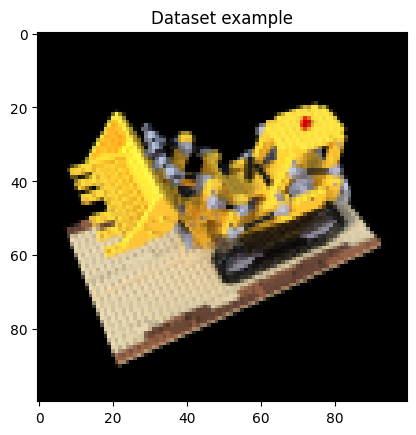

In [5]:
rawData = np.load("tiny_nerf_data.npz",allow_pickle=True)
images = rawData["images"]
poses = rawData["poses"]
focal = rawData["focal"]
H, W = images.shape[1:3]
H = int(H)
W = int(W)
print("Images: {}".format(images.shape))
print("Camera Poses: {}".format(poses.shape))
print("Focal Length: {:.4f}".format(focal))

testimg, testpose = images[99], poses[99]
plt.imshow(testimg)
plt.title('Dataset example')
plt.show()
images = torch.Tensor(images).to(device)
poses = torch.Tensor(poses).to(device)
testimg = torch.Tensor(testimg).to(device)
testpose = torch.Tensor(testpose).to(device)

### Generate Rays

Ray generation is a core component of NeRF. We will first implement a function that generates the camera rays for each pixel.

Each ray includes two components: 1) origin and 2) direction.

In [6]:
def get_rays(H, W, focal, pose):
  """
  This function generates camera rays for each pixel in an image. It calculates the origin and direction of rays
  based on the camera's intrinsic parameters (focal length) and extrinsic parameters (pose).
  The rays are generated in world coordinates, which is crucial for the NeRF rendering process.

  Parameters:
  H (int): Height of the image in pixels.
  W (int): Width of the image in pixels.
  focal (float): Focal length of the camera.
  pose (torch.Tensor): Camera pose matrix of size 4x4.

  Returns:
  tuple: A tuple containing two elements:
      rays_o (torch.Tensor): Origins of the rays in world coordinates. [H * W * 3]
      rays_d (torch.Tensor): Directions of the rays in world coordinates. [H * W * 3]
  """
  # Create a meshgrid of image coordinates (i, j) for each pixel in the image.
  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32),
      torch.arange(H, dtype=torch.float32)
  )
  i = i.t()
  j = j.t()

  # Calculate the direction vectors for each ray originating from the camera center.
  # We assume the camera looks towards -z.
  # The coordinates are normalized with respect to the focal length.
  dirs = torch.stack(
      [(i - W * 0.5) / focal,
        -(j - H * 0.5) / focal,
        -torch.ones_like(i)], -1
      ).to(device)

  # Transform the direction vectors (dirs) from camera coordinates to world coordinates.
  # This is done using the rotation part (first 3 columns) of the pose matrix.
  rays_d = torch.sum(dirs[..., np.newaxis, :] * pose[:3, :3], -1)

  # The ray origins (rays_o) are set to the camera position, given by the translation part (last column) of the pose matrix.
  # The position is expanded to match the shape of rays_d for broadcasting.
  rays_o = pose[:3, -1].expand(rays_d.shape)

  # Return the origins and directions of the rays.
  return rays_o, rays_d

### Positional Encoding

In the NeRF we leverage Fourier positional encoding to model the high frequencies.

Given an input $x$, we will encode it into $\gamma(x)=(x,\text{sin}(2^{0} x),\text{cos}(2^{0} x), \text{sin}(2^{1} x), \text{cos}(2^{1} x), \cdots, \text{sin}(2^{L\_embed-1} x), (2^{L\_embed-1} x))$.

In [7]:
def positional_encoder(x, L_embed=6):
  """
  This function applies positional encoding to the input tensor. Positional encoding is used in NeRF
  to allow the model to learn high-frequency details more effectively. It applies sinusoidal functions
  at different frequencies to the input.

  Parameters:
  x (torch.Tensor): The input tensor to be positionally encoded.
  L_embed (int): The number of frequency levels to use in the encoding. Defaults to 6.

  Returns:
  torch.Tensor: The positionally encoded tensor.
  """

  # Initialize a list with the input tensor.
  rets = [x]

  # Loop over the number of frequency levels.
  for i in range(L_embed):
    #############################################################################
    #                                   TODO                                    #
    #############################################################################
    rets.append(torch.sin(2 ** i * x))
    rets.append(torch.cos(2 ** i * x))
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


  # Concatenate the original and encoded features along the last dimension.
  return torch.cat(rets, -1)

### Cumulative Product

The RGB value of each pixel is computed by a weighted sum of the points along the ray. Higher weight indicates higher opacity, which means the further points will be occluded. The cumulative product fuction ensures this rendering procedure.

In [8]:
def cumprod_exclusive(tensor: torch.Tensor):
  """
  Compute the exclusive cumulative product of a tensor along its last dimension.
  'Exclusive' means that the cumulative product at each element does not include the element itself.
  This function is used in volume rendering to compute the product of probabilities
  along a ray, excluding the current sample point.

  Parameters:
  tensor (torch.Tensor): The input tensor for which to calculate the exclusive cumulative product.

  Returns:
  torch.Tensor: The tensor after applying the exclusive cumulative product.
  """

  # Compute the cumulative product along the last dimension of the tensor.
  cumprod = torch.cumprod(tensor, -1)

  # Roll the elements along the last dimension by one position.
  # This shifts the cumulative products to make them exclusive.
  cumprod = torch.roll(cumprod, 1, -1)

  # Set the first element of the last dimension to 1, as the exclusive product of the first element is always 1.
  cumprod[..., 0] = 1.

  return cumprod

### NeRF Model

The main model of NeRF will be implemented here. To reduce training time, we will only use a very small MLP model as our network. The MLP takes the output of positional encoder as input and predicts the opacity and RGB value.

In [9]:
class VeryTinyNerfModel(torch.nn.Module):
  """
  A very small implementation of a Neural Radiance Field (NeRF) model. This model is a simplified
  version of the standard NeRF architecture, it consists of a simple feedforward neural network with three linear layers.

  Parameters:
  filter_size (int): The number of neurons in the hidden layers. Default is 128.
  num_encoding_functions (int): The number of sinusoidal encoding functions. Default is 6.
  """

  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

### Volume Rendering

After the implementation of ray generation and MLP model, we can now implement the volume rendering, which is the major procedure of NeRF.

In [10]:
def render(model, rays_o, rays_d, near, far, n_samples, rand=False):
  """
  Render a scene using a Neural Radiance Field (NeRF) model. This function samples points along rays,
  evaluates the NeRF model at these points, and applies volume rendering techniques to produce an image.

  Parameters:
  model (torch.nn.Module): The NeRF model to be used for rendering.
  rays_o (torch.Tensor): Origins of the rays.
  rays_d (torch.Tensor): Directions of the rays.
  near (float): Near bound for depth sampling along the rays.
  far (float): Far bound for depth sampling along the rays.
  n_samples (int): Number of samples to take along each ray.
  rand (bool): If True, randomize sample depths. Default is False.

  Returns:
  tuple: A tuple containing the RGB map and depth map of the rendered scene.
  """

  # Sample points along each ray, from 'near' to 'far'.
  z = torch.linspace(near, far, n_samples).to(device)
  if rand:
    mids = 0.5 * (z[..., 1:] + z[..., :-1])
    upper = torch.cat([mids, z[..., -1:]], -1)
    lower = torch.cat([z[..., :1], mids], -1)
    t_rand = torch.rand(z.shape).to(device)
    z = lower + (upper - lower) * t_rand

  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # Compute 3D coordinates of the sampled points along the rays.
  points = rays_o[..., None, :] + rays_d[..., None, :] * z[..., :, None]
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  # Flatten the points and apply positional encoding.
  flat_points = torch.reshape(points, [-1, points.shape[-1]])
  flat_points = positional_encoder(flat_points)

  # Evaluate the model on the encoded points in chunks to manage memory usage.
  chunk = 1024 * 32
  raw = torch.cat([model(flat_points[i:i + chunk]) for i in range(0, flat_points.shape[0], chunk)], 0)
  raw = torch.reshape(raw, list(points.shape[:-1]) + [4])

  # Compute densities (sigmas) and RGB values from the model's output.
  sigma = F.relu(raw[..., 3])
  rgb = torch.sigmoid(raw[..., :3])

  # Perform volume rendering to obtain the weights of each point.
  one_e_10 = torch.tensor([1e10], dtype=rays_o.dtype).to(device)
  dists = torch.cat((z[..., 1:] - z[..., :-1], one_e_10.expand(z[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # Compute the weighted sum of RGB values along each ray to get the final pixel color.
  rgb_map = torch.sum(rgb * weights[..., None], dim=-2)
  # Compute the depth map as the weighted sum of sampled depths.
  depth_map = torch.sum(weights * z, dim=-1)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return rgb_map, depth_map

#Testing your rendering
Here we provided you with correct pretrained weight and the inference code. Please run this to test your implementation for rendering!

The output image might be a bit blury but that's fine due to the limited data size used to train the model.

In [12]:
!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1Mj9A7f4BsbPLw2cUGcUgCkDArTJz9q_h'
output = 'pretrained.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Mj9A7f4BsbPLw2cUGcUgCkDArTJz9q_h
To: /content/pretrained.pth
100%|██████████| 91.0k/91.0k [00:00<00:00, 39.7MB/s]


'pretrained.pth'

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


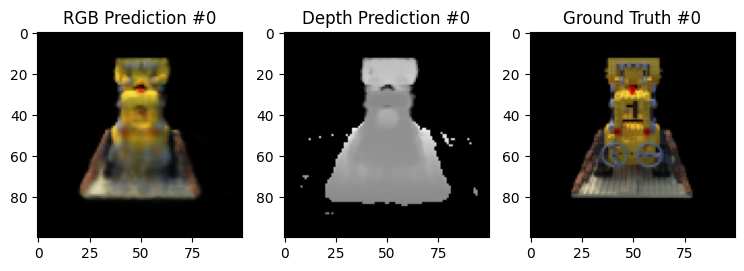

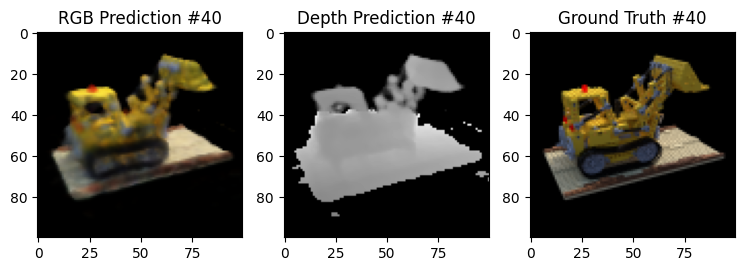

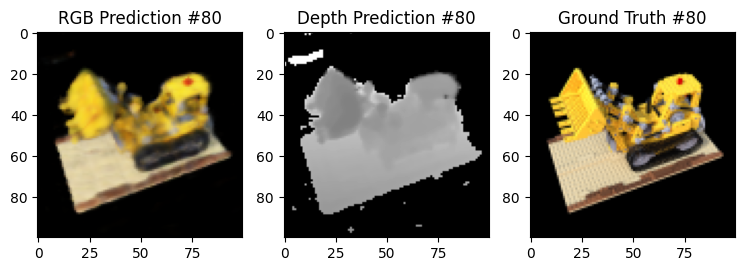

In [13]:
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
ckpt = torch.load('pretrained.pth')
nerf.load_state_dict(ckpt)
test_img_idx_list = [0, 40, 80]
H, W = 100, 100
with torch.no_grad():
  for test_img_idx in test_img_idx_list:
    rays_o, rays_d = get_rays(H, W, focal, poses[test_img_idx])
    # TODO: add your own function call to render
    # import pdb; pdb.set_trace()
    rgb, depth = render(nerf, rays_o, rays_d, near=1., far=6., n_samples=64, rand=True)
    #
    plt.figure(figsize=(9,3))

    plt.subplot(131)
    picture = rgb.cpu()
    plt.title("RGB Prediction #{}".format(test_img_idx))
    plt.imshow(picture)

    plt.subplot(132)
    picture = depth.cpu() * (rgb.cpu().mean(-1)>1e-2)
    plt.imshow(picture, cmap='gray')
    plt.title("Depth Prediction #{}".format(test_img_idx))

    plt.subplot(133)
    plt.title("Ground Truth #{}".format(test_img_idx))
    plt.imshow(rawData["images"][test_img_idx])
    plt.show()

### Training Loop

In the training loop, the model is trained to fit one image randomly picked from the dataset at each iteration.

In [14]:
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.])).to(device)

def train(model, optimizer, n_iters=3000):
  """
  Train the Neural Radiance Field (NeRF) model. This function performs training over a specified number of iterations,
  updating the model parameters to minimize the difference between rendered and actual images.

  Parameters:
  model (torch.nn.Module): The NeRF model to be trained.
  optimizer (torch.optim.Optimizer): The optimizer used for training the model.
  n_iters (int): The number of iterations to train the model. Default is 3000.
  """

  psnrs = []
  iternums = []

  plot_step = 500
  n_samples = 64   # Number of samples along each ray.

  for i in tqdm(range(n_iters)):
    # Randomly select an image from the dataset and use it as the target for training.
    images_idx = np.random.randint(images.shape[0])
    target = images[images_idx]
    pose = poses[images_idx]


    #############################################################################
    #                                   TODO                                    #
    #############################################################################
    # Perform training. Use mse loss for loss calculation and update the model parameter using the optimizer.
    # Hint: focal is defined as a global variable in previous section
    rays_o, rays_d = get_rays(H, W, focal=focal, pose=pose)
    rgb, depth = render(model=model, rays_o=rays_o, rays_d=rays_d, near=1., far=6., n_samples=n_samples, rand=True)

    loss = torch.nn.functional.mse_loss(rgb, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    if i % plot_step == 0:
      torch.save(model.state_dict(), 'ckpt.pth')
      # Render a test image to evaluate the current model performance.
      with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth = render(model, rays_o, rays_d, near=2., far=6., n_samples=n_samples)
        loss = torch.nn.functional.mse_loss(rgb, testimg)
        # Calculate PSNR for the rendered image.
        psnr = mse2psnr(loss)

        psnrs.append(psnr.detach().cpu().numpy())
        iternums.append(i)

        # Plotting the rendered image and PSNR over iterations.
        plt.figure(figsize=(9, 3))

        plt.subplot(131)
        picture = rgb.cpu()  # Copy the rendered image from GPU to CPU.
        plt.imshow(picture)
        plt.title(f'RGB Iter {i}')

        plt.subplot(132)
        picture = depth.cpu() * (rgb.cpu().mean(-1)>1e-2)
        plt.imshow(picture, cmap='gray')
        plt.title(f'Depth Iter {i}')

        plt.subplot(133)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()


  0%|          | 0/3000 [00:00<?, ?it/s]

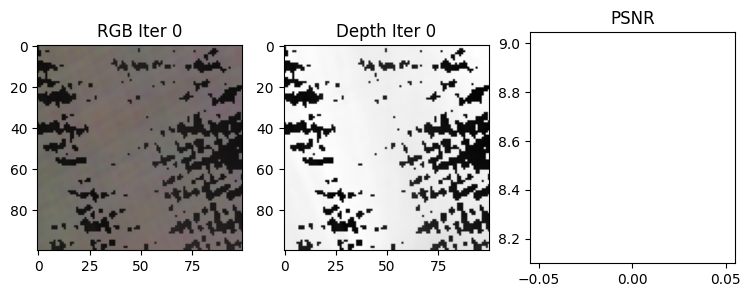

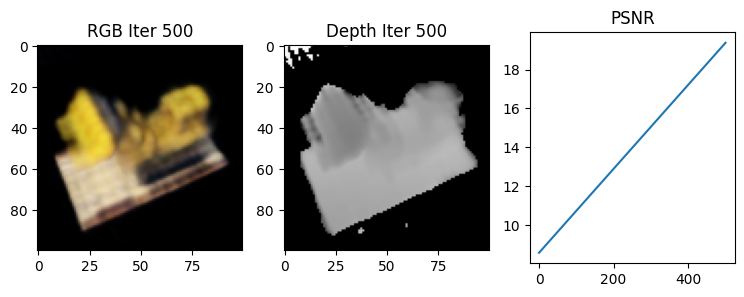

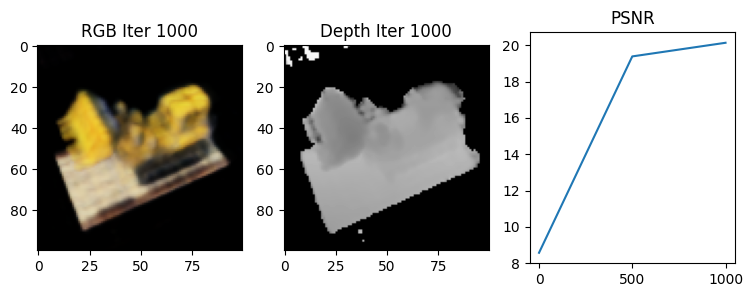

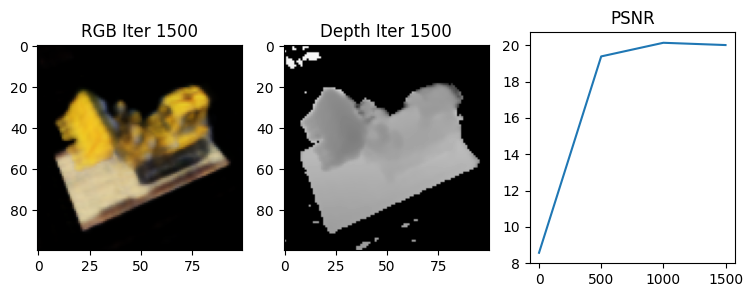

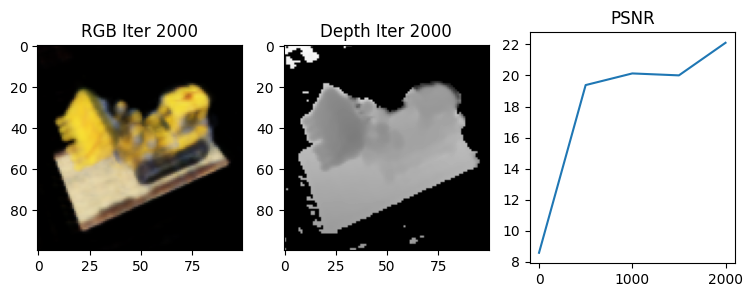

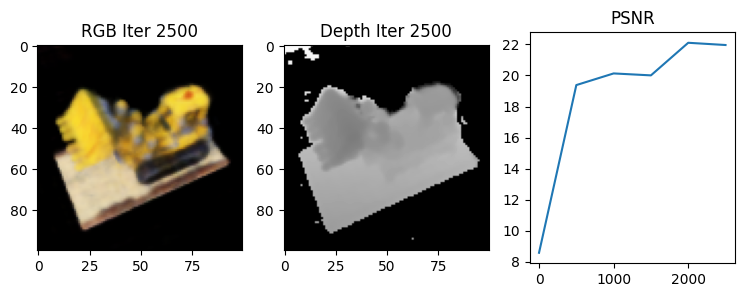

In [15]:
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
optimizer = torch.optim.Adam(nerf.parameters(), lr=5e-3, eps = 1e-7)
train(nerf, optimizer)

### Rendering from different view points.

Given the trained model, we can query it with different camera poses.
In this example, we simply pick three camera poses from the dataset and render the prediction images from them.

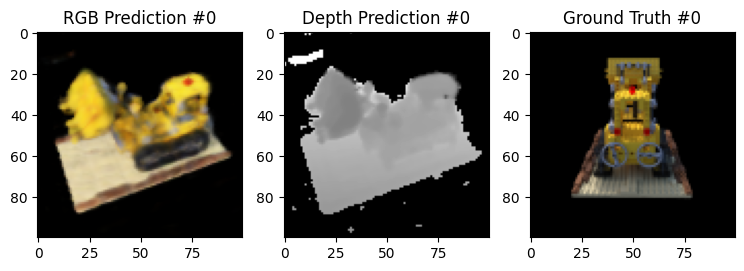

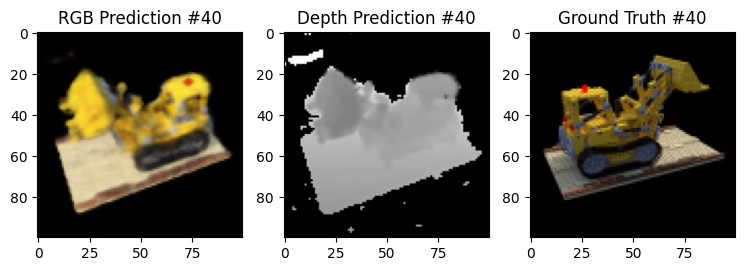

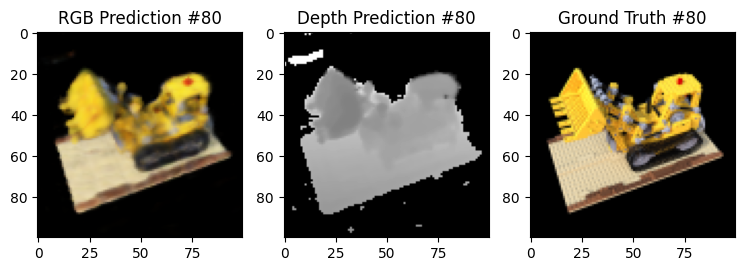

In [16]:
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
ckpt = torch.load('ckpt.pth')
nerf.load_state_dict(ckpt)
test_img_idx_list = [0, 40, 80]
H, W = 100, 100
with torch.no_grad():
  for test_img_idx in test_img_idx_list:
    rays_o, rays_d = get_rays(H, W, focal, poses[test_img_idx])
    ## TODO: add your own function call to render

    #
    plt.figure(figsize=(9,3))

    plt.subplot(131)
    picture = rgb.cpu()
    plt.title("RGB Prediction #{}".format(test_img_idx))
    plt.imshow(picture)

    plt.subplot(132)
    picture = depth.cpu() * (rgb.cpu().mean(-1)>1e-2)
    plt.imshow(picture, cmap='gray')
    plt.title("Depth Prediction #{}".format(test_img_idx))

    plt.subplot(133)
    plt.title("Ground Truth #{}".format(test_img_idx))
    plt.imshow(rawData["images"][test_img_idx])
    plt.show()

In [17]:
# generate pdf
# %%capture
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
drive_mount_point = "/content/drive/"
gdrive_home = os.path.join(drive_mount_point, "My Drive/")
notebookpath="/content/drive/MyDrive/Colab Notebooks/"
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
file_name=""
get_ipython().system(
  f"jupyter nbconvert --output-dir='{gdrive_home}' '{notebookpath}''{file_name}' --to pdf"
)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo